# This notebook must be run under Python 3

Requirement: polarTransform, peakutils.peak

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import urllib

from astropy import wcs
from astropy.io import fits
from astropy.table import Table

from kungpao.display import display_single

import polarTransform
import peakutils.peak

import koi

from IPython.display import clear_output

plt.rc('font', size=20)
plt.rc('text', usetex=True)

In [2]:
ring_cat = Table.read('../Catalogs/Ring-MPA-UV-GZ-Mendel-Simard.fits', format='fits')

## Download `Pipe3D` cubes from MaNGA

MaNGA Pipe3D datacube datamodel: https://data.sdss.org/datamodel/files/MANGA_PIPE3D/MANGADRP_VER/PIPE3D_VER/PLATE/manga.Pipe3D.cube.html

MaNGA Pipe3D catalog datamodel: https://data.sdss.org/datamodel/files/MANGA_PIPE3D/MANGADRP_VER/PIPE3D_VER/manga.Pipe3D.html

In [3]:
#path = '/Users/jiaxuanli/Research/MaNGA/v2_1_2/'
#for obj in ring_cat:
#    url = gen_url_manga(obj['plate_1'], obj['mangaid'].rstrip(' '))[0]
#    urllib.request.urlretrieve(url, filename = path + obj['mangaid'].rstrip(' ') + '.Pipe3D.cube.fits.gz')

## Measure the radius of H-alpha ring

In [58]:
peak_array = []
peak_std = []
trough_array = []
trough_std = []

manga-8626-6104 
spaxel_scale:  0.5000004 0.5000004
extent (arcsec):  [13.5000108, -13.5000108, -13.5000108, 13.5000108]
At redshift 0.028476136 , 1 arcsec = 0.5634998334962699 kpc
r_max (pixel):  40.0
x_length (degrees):  360


No handles with labels found to put in legend.


At redshift 0.028476136 , 1 arcsec = 0.5634998334962699 kpc
peak reliable 5.122729857237607
trough reliable 2.7321225905267235


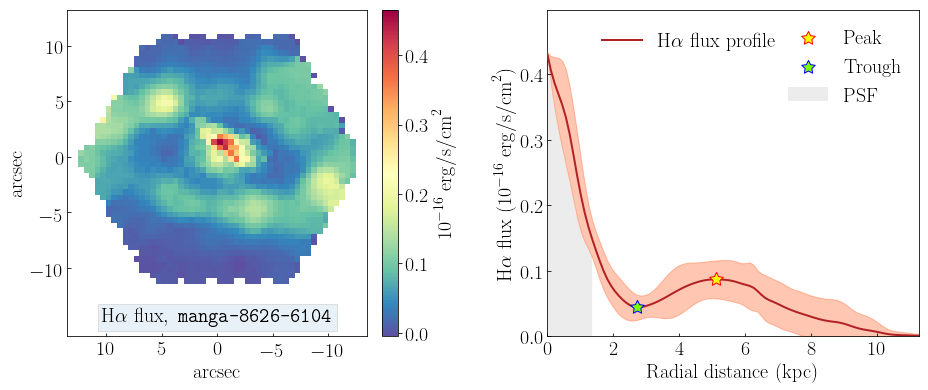

peaks 5.158019774031909
std 0.4804724002590757
troughs 2.8368539564969137
std 0.2949624090606973
-----------------------------------
manga-8623-3701 
spaxel_scale:  0.5000004 0.5000004
extent (arcsec):  [11.0000088, -11.0000088, -11.0000088, 11.0000088]
At redshift 0.027274933 , 1 arcsec = 0.5404950082356549 kpc
r_max (pixel):  30.0
x_length (degrees):  360


No handles with labels found to put in legend.


At redshift 0.027274933 , 1 arcsec = 0.5404950082356549 kpc
peak reliable 3.3576231918027455
trough reliable 2.047331214513869


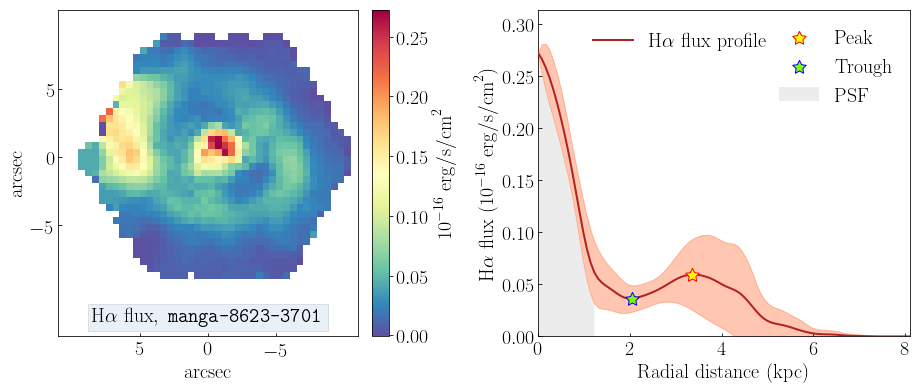

peaks 3.2609891584776913
std 0.39092855391557524
troughs 1.8982855020972595
std 0.2588085798020289
-----------------------------------
manga-8616-12702
spaxel_scale:  0.5000004 0.5000004
extent (arcsec):  [18.5000148, -18.5000148, -18.5000148, 18.5000148]
At redshift 0.030827526 , 1 arcsec = 0.6083429397829373 kpc
r_max (pixel):  50.0
x_length (degrees):  360


No handles with labels found to put in legend.


At redshift 0.030827526 , 1 arcsec = 0.6083429397829373 kpc
peak reliable 8.295592178963034
trough reliable 3.3796857025404954


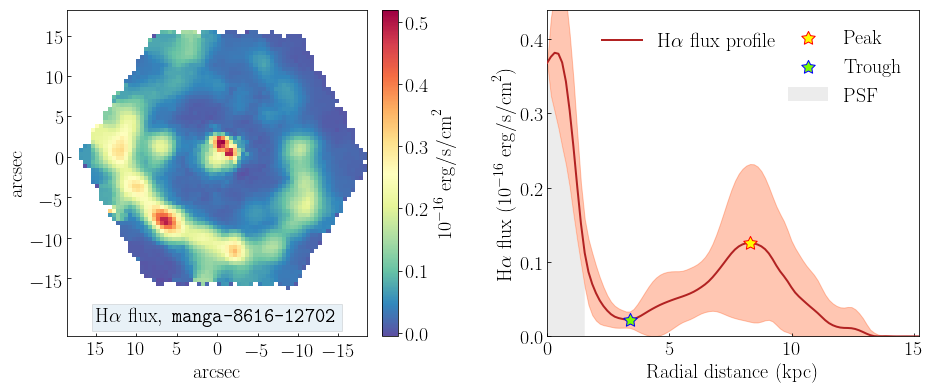

peaks 8.084555789823684
std 0.9554070851138587
troughs 3.27829513146428
std 0.35713085730229593
-----------------------------------
manga-7975-6102 
spaxel_scale:  0.5000004 0.5000004
extent (arcsec):  [13.5000108, -13.5000108, -13.5000108, 13.5000108]
At redshift 0.034497526 , 1 arcsec = 0.6778351154285315 kpc
r_max (pixel):  40.0
x_length (degrees):  360


No handles with labels found to put in legend.


At redshift 0.034497526 , 1 arcsec = 0.6778351154285315 kpc
peak reliable 4.792777377652896
trough reliable 2.1909839440698953


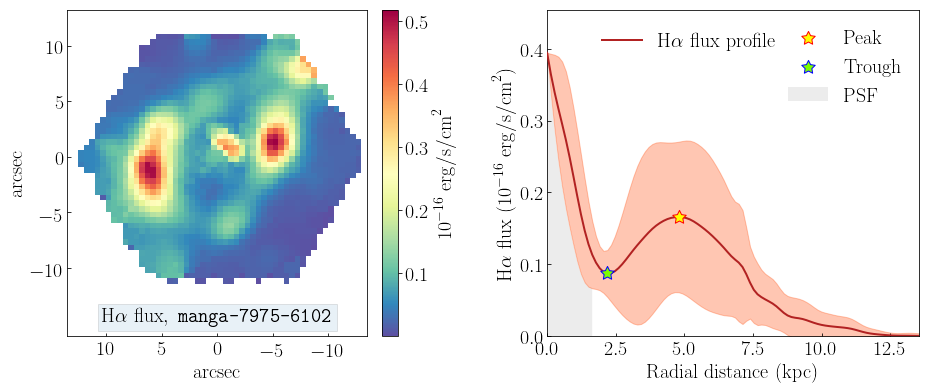

peaks 4.596958187651649
std 0.8078684639141361
troughs 2.370370754490618
std 0.289642540851054
-----------------------------------


In [59]:
for obj in ring_cat[80:]:
    print(obj['mangaid'])
    cubeset = fits.open('/Users/jiaxuanli/Research/MaNGA/v2_1_2/' + obj['mangaid'].rstrip(' ') + '.Pipe3D.cube.fits.gz')
    ha_im = cubeset[3].data[45]            # H-alpha image
    mask = np.isnan(cubeset[1].data[18])
    dx = -cubeset[3].header['CD1_1']*3600
    dy = cubeset[3].header['CD2_2']*3600
    print('spaxel_scale: ', dx, dy)

    x_center = np.int(cubeset[3].header['CRPIX1']) - 1
    y_center = np.int(cubeset[3].header['CRPIX2']) - 1
    x_extent = (np.array([0., ha_im.shape[0]]) - (ha_im.shape[0] - x_center)) * dx * (-1)
    y_extent = (np.array([0., ha_im.shape[1]]) - (ha_im.shape[1] - y_center)) * dy
    extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]] # arcsec
    print('extent (arcsec): ', extent)

    # The shape of this galaxy
    pa = np.deg2rad(obj['pa'])
    phys_scale = koi.phys_size(obj['redshift'], h=0.71, Omegam=0.27, Omegal=0.73)
    ba = obj['nsa_sersic_ba']  ## nsa_ELPETRO_BA  ## nsa_ELPETRO_PHI
    if np.isnan(ba):
        ba = 1 / 3

    # Apply polar transformation to this H-alpha image
    r_max = 10 * (round(extent[0] / dx / 10) + 1) # pixel
    polarImage, ptSettings = polarTransform.convertToPolarImage(
                                                                ha_im,
                                                                initialRadius=0,
                                                                finalRadius=r_max,
                                                                initialAngle=0,
                                                                finalAngle=np.deg2rad(360),
                                                                radiusSize=r_max,
                                                                angleSize=360,
                                                                center=(x_center+1, y_center+1))
    xlength = polarImage.shape[1]  #0 is width, and 1 is length of polarImage
    print ('r_max (pixel): ', r_max)
    print ('x_length (degrees): ', xlength)
    
    #### Interpolate the profile of every direction, then stack them together
    x_input = np.linspace(0, r_max * dx * phys_scale, 100)
    y_output, y_std = koi.eat_pizza(0, 360, polarImage, x_input, r_max, dx, phys_scale, pa, ba)
    ####

    plt.rc('font', size=20)
    plt.rc('text', usetex=True)
    fig, ax, peaks_reliable, troughs_reliable = koi.show_ha_profile(obj, x_input, y_output, y_std, r_max)
    plt.savefig('../Figures/RingRadius/' + obj['mangaid'] + '.png', dpi=200, bbox_inches='tight')
    plt.show()

    peak_set = []
    trough_set = []
    # Interpolate the profile of every direction, then stack them together
    from scipy import interpolate
    x_input = np.linspace(0, r_max * dx * phys_scale, 100)

    for i in range(100):
        init_ang = round(np.random.rand()*360)
        y_output, y_std = koi.eat_pizza(init_ang, 120, polarImage, x_input, r_max, dx, phys_scale, pa, ba)
        #plt.plot(x_input, y_output, linewidth=2, linestyle='-', c="orange", zorder=9)

        ## Peaks
        peak_indices = peakutils.peak.indexes(y_output, thres=0.0, min_dist=5)
        peaks = x_input[peak_indices]
        if peaks.size > 0:
            fine = peaks[abs(peaks - peaks_reliable) < 2]
            if fine.size > 0:
                pos = fine[koi.find_nearest(fine, peaks_reliable)]
                peak_set.append(pos)

        ## Troughs
        trough_indices = peakutils.peak.indexes(1 - y_output, thres=0.0, min_dist=5)
        troughs = x_input[trough_indices]
        if troughs.size > 0:
            fine = troughs[abs(troughs - troughs_reliable) < 2]
            if fine.size > 0:
                pos = fine[koi.find_nearest(fine, troughs_reliable)]
                trough_set.append(pos)

    print('peaks', np.array(peak_set).mean())
    peak_array.append(np.array(peak_set).mean())
    print('std', np.array(peak_set).std())
    peak_std.append(np.array(peak_set).std())

    print('troughs', np.array(trough_set).mean())
    trough_array.append(np.array(trough_set).mean())
    print('std', np.array(trough_set).std())
    trough_std.append(np.array(trough_set).std())
    print('-----------------------------------')

### How to estimate the error of peak and trough?

In [60]:
peak_array, peak_std, trough_array, trough_std

([5.158019774031909, 3.2609891584776913, 8.084555789823684, 4.596958187651649],
 [0.4804724002590757,
  0.39092855391557524,
  0.9554070851138587,
  0.8078684639141361],
 [2.8368539564969137, 1.8982855020972595, 3.27829513146428, 2.370370754490618],
 [0.2949624090606973,
  0.2588085798020289,
  0.35713085730229593,
  0.289642540851054])